In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Molecules 

In [3]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"
basis = "6-311++g**"

data = ScreenedData(r_max=10)

data.include(data_path = "../../thesis/dataset/MethanT/", postfix = "MethanT", target=target)

In [4]:
#data = Data()

#data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../thesis/dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../thesis/dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../thesis/dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../thesis/dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../thesis/dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../thesis/dataset/EthanT3/", postfix = "EthanT3", target=target)

data.include(data_path = "../../thesis/dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../thesis/dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../thesis/dataset/EthenT3/", postfix = "EthenT3", target=target)

data.include(data_path = "../../thesis/dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../thesis/dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../thesis/dataset/EthinT3/", postfix = "EthinT3", target=target)

# Descriptor 

In [5]:
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS, make_uniform
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
import pickle

model = make_uniform(25, 5, eta_max=60, eta_min=20)

descriptor_C = AtomicNumberWeighted(
    Gaussians(*model),
    SPHAngularDescriptor(4),
    BehlerCutoff1(5)
)


#pickle.dump(descriptor, open(model_path + "descriptor.dump", "wb"))
    
descriptor_C.radial_descriptor.number_of_descriptors, descriptor_C.angular_descriptor.number_of_descriptors, descriptor_C.number_of_descriptors

(25, 50, 75)

In [6]:
descriptor_H = descriptor_C

# Package Dataset 

In [7]:
from SCFInitialGuess.utilities.dataset import make_block_dataset, extract_HETERO_block_dataset_pairs

dataset = make_block_dataset(
    [descriptor_C, descriptor_H],
    data.molecules,
    data.T,
    ["C", "H"],
    extract_HETERO_block_dataset_pairs
)

#np.save(model_path + "normalisation.npy", (dataset.x_mean, dataset.x_std))


In [8]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(35440, 8880, 11140)

In [9]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS


dim_C = N_BASIS[basis]["C"]
dim_H = N_BASIS[basis]["H"]

# NN Utils 

In [10]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(5e-3)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [11]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath=None, learning_rate=1e-4, log_dir=None):

    if not log_dir is None:
        tensorboard = keras.callbacks.TensorBoard(
            log_dir=log_dir, 
            histogram_freq=0, 
            batch_size=32, 
            #update_freq='epoch'
        )
    
    if not filepath is None:
        checkpoint = keras.callbacks.ModelCheckpoint(
            filepath, 
            monitor='val_mean_squared_error', 
            verbose=1, 
            save_best_only=True, 
            save_weights_only=False, 
            mode='auto', 
            period=1
        )
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                #checkpoint,
                #tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

# Training 

In [12]:
dataset.training[0].shape, dataset.training[1].shape

((35440, 150), (35440, 154))

In [13]:
descriptor_C.number_of_descriptors, descriptor_H.number_of_descriptors, dim_C * dim_H

(75, 75, 154)

In [14]:
structure = [200, 200]

In [15]:
keras.backend.clear_session()

In [16]:
model = make_model(
    structure=structure,
    input_dim=descriptor_C.number_of_descriptors + descriptor_H.number_of_descriptors,
    output_dim=dim_C * dim_H,
    
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               30200     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 154)               30954     
Total params: 101,354
Trainable params: 101,354
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_path="models/"

Train on 35440 samples, validate on 8880 samples
Epoch 1/1000
35440/35440 [==============================] - 3s 79us/step - loss: 5.1395e-04 - mean_squared_error: 3.5811e-04 - val_loss: 3.6483e-04 - val_mean_squared_error: 2.9660e-04
Epoch 2/1000
35440/35440 [==============================] - 3s 73us/step - loss: 3.2587e-04 - mean_squared_error: 2.6846e-04 - val_loss: 3.0919e-04 - val_mean_squared_error: 2.5642e-04
Epoch 3/1000
35440/35440 [==============================] - 3s 95us/step - loss: 2.6655e-04 - mean_squared_error: 2.1864e-04 - val_loss: 2.9375e-04 - val_mean_squared_error: 2.3882e-04
Epoch 4/1000
35440/35440 [==============================] - 4s 111us/step - loss: 2.3471e-04 - mean_squared_error: 1.9242e-04 - val_loss: 3.2881e-04 - val_mean_squared_error: 2.5017e-04
Epoch 5/1000
35440/35440 [==============================] - 3s 93us/step - loss: 2.5128e-04 - mean_squared_error: 1.9124e-04 - val_loss: 2.6459e-04 - val_mean_squared_error: 2.2889e-04
Epoch 6/1000
35440/35440 

35440/35440 [==============================] - 7s 202us/step - loss: 1.4528e-04 - mean_squared_error: 1.3291e-04 - val_loss: 2.1602e-04 - val_mean_squared_error: 2.0365e-04
Epoch 42/1000
35440/35440 [==============================] - 6s 176us/step - loss: 1.4528e-04 - mean_squared_error: 1.3291e-04 - val_loss: 2.1602e-04 - val_mean_squared_error: 2.0365e-04

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 43/1000
35440/35440 [==============================] - 6s 180us/step - loss: 1.4528e-04 - mean_squared_error: 1.3291e-04 - val_loss: 2.1602e-04 - val_mean_squared_error: 2.0365e-04
Epoch 44/1000
35440/35440 [==============================] - 5s 142us/step - loss: 1.4528e-04 - mean_squared_error: 1.3291e-04 - val_loss: 2.1602e-04 - val_mean_squared_error: 2.0365e-04
Epoch 45/1000
35440/35440 [==============================] - 5s 141us/step - loss: 1.4528e-04 - mean_squared_error: 1.3291e-04 - val_loss: 2.1602e-04 - val_mean_squared_error: 2.0365e-04
Epoch 46/1000


Epoch 35/1000
35440/35440 [==============================] - 6s 180us/step - loss: 1.4032e-04 - mean_squared_error: 1.2798e-04 - val_loss: 2.1704e-04 - val_mean_squared_error: 2.0469e-04

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1e-10.
Epoch 36/1000
35440/35440 [==============================] - 6s 183us/step - loss: 1.4032e-04 - mean_squared_error: 1.2798e-04 - val_loss: 2.1704e-04 - val_mean_squared_error: 2.0469e-04
Epoch 37/1000
35440/35440 [==============================] - 6s 171us/step - loss: 1.4032e-04 - mean_squared_error: 1.2798e-04 - val_loss: 2.1704e-04 - val_mean_squared_error: 2.0469e-04
Epoch 00037: early stopping
Train on 35440 samples, validate on 8880 samples
Epoch 1/1000
35440/35440 [==============================] - 6s 167us/step - loss: 2.1039e-04 - mean_squared_error: 1.6014e-04 - val_loss: 3.0009e-04 - val_mean_squared_error: 2.5350e-04
Epoch 2/1000
35440/35440 [==============================] - 6s 175us/step - loss: 2.0403e-04 - mean_squared_err

Epoch 3/1000
35440/35440 [==============================] - 8s 223us/step - loss: 1.7614e-04 - mean_squared_error: 1.4505e-04 - val_loss: 2.5866e-04 - val_mean_squared_error: 2.2712e-04
Epoch 4/1000
35440/35440 [==============================] - 6s 165us/step - loss: 1.7633e-04 - mean_squared_error: 1.4521e-04 - val_loss: 2.5683e-04 - val_mean_squared_error: 2.2501e-04

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/1000
35440/35440 [==============================] - 6s 165us/step - loss: 1.4440e-04 - mean_squared_error: 1.2797e-04 - val_loss: 2.2442e-04 - val_mean_squared_error: 2.0849e-04
Epoch 6/1000
35440/35440 [==============================] - 6s 181us/step - loss: 1.4233e-04 - mean_squared_error: 1.2707e-04 - val_loss: 2.2267e-04 - val_mean_squared_error: 2.0783e-04
Epoch 7/1000
35440/35440 [==============================] - 6s 182us/step - loss: 1.4105e-04 - mean_squared_error: 1.2658e-04 - val_loss: 2.1851e-04 - val_mean_squared_error:

35440/35440 [==============================] - 6s 165us/step - loss: 1.4291e-04 - mean_squared_error: 1.2647e-04 - val_loss: 2.2413e-04 - val_mean_squared_error: 2.0813e-04
Epoch 9/1000
35440/35440 [==============================] - 6s 171us/step - loss: 1.4103e-04 - mean_squared_error: 1.2559e-04 - val_loss: 2.2165e-04 - val_mean_squared_error: 2.0677e-04
Epoch 10/1000
35440/35440 [==============================] - 8s 217us/step - loss: 1.3971e-04 - mean_squared_error: 1.2511e-04 - val_loss: 2.2234e-04 - val_mean_squared_error: 2.0813e-04
Epoch 11/1000
35440/35440 [==============================] - 8s 233us/step - loss: 1.3864e-04 - mean_squared_error: 1.2478e-04 - val_loss: 2.2445e-04 - val_mean_squared_error: 2.1069e-04
Epoch 12/1000
35440/35440 [==============================] - 6s 168us/step - loss: 1.3777e-04 - mean_squared_error: 1.2448e-04 - val_loss: 2.1838e-04 - val_mean_squared_error: 2.0572e-04
Epoch 13/1000
35440/35440 [==============================] - 8s 236us/step - los

35440/35440 [==============================] - 8s 228us/step - loss: 1.3033e-04 - mean_squared_error: 1.1961e-04 - val_loss: 2.1818e-04 - val_mean_squared_error: 2.0752e-04

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 16/1000
35440/35440 [==============================] - 6s 178us/step - loss: 1.2993e-04 - mean_squared_error: 1.1933e-04 - val_loss: 2.1786e-04 - val_mean_squared_error: 2.0727e-04
Epoch 17/1000
35440/35440 [==============================] - 6s 179us/step - loss: 1.2984e-04 - mean_squared_error: 1.1924e-04 - val_loss: 2.1768e-04 - val_mean_squared_error: 2.0711e-04
Epoch 18/1000
35440/35440 [==============================] - 6s 173us/step - loss: 1.2981e-04 - mean_squared_error: 1.1923e-04 - val_loss: 2.1780e-04 - val_mean_squared_error: 2.0722e-04
Epoch 19/1000
35440/35440 [==============================] - 6s 166us/step - loss: 1.2980e-04 - mean_squared_error: 1.1923e-04 - val_loss: 2.1761e-04 - val_mean_squared_error: 2.0704e-

35440/35440 [==============================] - 9s 246us/step - loss: 1.3076e-04 - mean_squared_error: 1.1896e-04 - val_loss: 2.1930e-04 - val_mean_squared_error: 2.0751e-04
Epoch 21/1000
35440/35440 [==============================] - 8s 228us/step - loss: 1.3076e-04 - mean_squared_error: 1.1896e-04 - val_loss: 2.1929e-04 - val_mean_squared_error: 2.0749e-04

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 22/1000
35440/35440 [==============================] - 8s 225us/step - loss: 1.3075e-04 - mean_squared_error: 1.1896e-04 - val_loss: 2.1929e-04 - val_mean_squared_error: 2.0749e-04
Epoch 23/1000
35440/35440 [==============================] - 8s 229us/step - loss: 1.3075e-04 - mean_squared_error: 1.1896e-04 - val_loss: 2.1928e-04 - val_mean_squared_error: 2.0749e-04
Epoch 24/1000
35440/35440 [==============================] - 8s 227us/step - loss: 1.3075e-04 - mean_squared_error: 1.1896e-04 - val_loss: 2.1928e-04 - val_mean_squared_error: 2.0749e-0

35440/35440 [==============================] - 8s 237us/step - loss: 1.2957e-04 - mean_squared_error: 1.1787e-04 - val_loss: 2.2032e-04 - val_mean_squared_error: 2.0862e-04
Epoch 30/1000
35440/35440 [==============================] - 8s 229us/step - loss: 1.2957e-04 - mean_squared_error: 1.1787e-04 - val_loss: 2.2032e-04 - val_mean_squared_error: 2.0862e-04
Epoch 31/1000
35440/35440 [==============================] - 8s 227us/step - loss: 1.2957e-04 - mean_squared_error: 1.1787e-04 - val_loss: 2.2032e-04 - val_mean_squared_error: 2.0862e-04
Epoch 32/1000
35440/35440 [==============================] - 7s 204us/step - loss: 1.2957e-04 - mean_squared_error: 1.1787e-04 - val_loss: 2.2032e-04 - val_mean_squared_error: 2.0862e-04

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 33/1000
35440/35440 [==============================] - 6s 176us/step - loss: 1.2957e-04 - mean_squared_error: 1.1787e-04 - val_loss: 2.2032e-04 - val_mean_squared_error: 2.0862e-0

35440/35440 [==============================] - 9s 259us/step - loss: 1.7022e-04 - mean_squared_error: 1.3866e-04 - val_loss: 2.6038e-04 - val_mean_squared_error: 2.3118e-04
Epoch 4/1000
35440/35440 [==============================] - 8s 227us/step - loss: 1.6862e-04 - mean_squared_error: 1.3802e-04 - val_loss: 2.5929e-04 - val_mean_squared_error: 2.3148e-04
Epoch 5/1000
35440/35440 [==============================] - 9s 255us/step - loss: 1.7008e-04 - mean_squared_error: 1.3856e-04 - val_loss: 2.5934e-04 - val_mean_squared_error: 2.2812e-04
Epoch 6/1000
35440/35440 [==============================] - 8s 238us/step - loss: 1.6945e-04 - mean_squared_error: 1.3832e-04 - val_loss: 2.7882e-04 - val_mean_squared_error: 2.3990e-04
Epoch 7/1000
35440/35440 [==============================] - 6s 166us/step - loss: 1.8004e-04 - mean_squared_error: 1.4293e-04 - val_loss: 2.6278e-04 - val_mean_squared_error: 2.3121e-04
Epoch 8/1000
35440/35440 [==============================] - 8s 234us/step - loss: 1

35440/35440 [==============================] - 8s 234us/step - loss: 1.2815e-04 - mean_squared_error: 1.1677e-04 - val_loss: 2.2674e-04 - val_mean_squared_error: 2.1547e-04
Epoch 13/1000
35440/35440 [==============================] - 6s 165us/step - loss: 1.2776e-04 - mean_squared_error: 1.1651e-04 - val_loss: 2.2662e-04 - val_mean_squared_error: 2.1537e-04
Epoch 14/1000
35440/35440 [==============================] - 8s 233us/step - loss: 1.2762e-04 - mean_squared_error: 1.1642e-04 - val_loss: 2.2631e-04 - val_mean_squared_error: 2.1514e-04
Epoch 15/1000
35440/35440 [==============================] - 10s 271us/step - loss: 1.2750e-04 - mean_squared_error: 1.1636e-04 - val_loss: 2.2607e-04 - val_mean_squared_error: 2.1498e-04

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 16/1000
35440/35440 [==============================] - 9s 265us/step - loss: 1.2710e-04 - mean_squared_error: 1.1609e-04 - val_loss: 2.2564e-04 - val_mean_squared_error: 2.1465e

13024/35440 [==========>...................] - ETA: 5s - loss: 1.2687e-04 - mean_squared_error: 1.1548e-04

KeyboardInterrupt: 

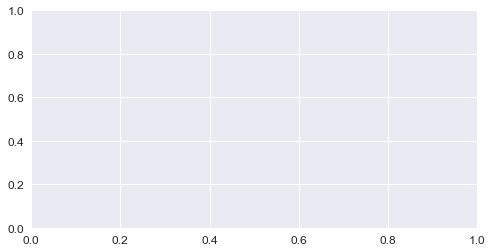

In [18]:
#i+=1
train_model(
    model, 
    dataset, 
    #model_path + name_folder,
    learning_rate=1e-3,
    #log_dir=None#"./logs/H/" + name + "_" + "x".join(list(map(str, structure))) + "_" + str(i)
)